# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


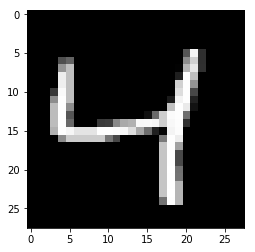

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [132]:
learning_rate = 0.001
# Input and target placeholders
inputs_ = tf.placeholder(tf.float32, [None, 28, 28, 1])
targets_ = tf.placeholder(tf.float32, [None, 28, 28, 1])

## Weights
weights = {
    'wc1' : tf.Variable(tf.truncated_normal([3, 3, 1, 16], stddev = 0.1)),
    'wc2' : tf.Variable(tf.truncated_normal([3, 3, 16, 8], stddev = 0.1)),
    'wc3' : tf.Variable(tf.truncated_normal([3, 3, 8, 8], stddev = 0.1)),
    'wc4' : tf.Variable(tf.truncated_normal([3, 3, 8, 8], stddev = 0.1)),
    'wc5' : tf.Variable(tf.truncated_normal([3, 3, 8, 8], stddev = 0.1)),
    'wc6' : tf.Variable(tf.truncated_normal([3, 3, 8, 16], stddev = 0.1)),
    'wc7' : tf.Variable(tf.truncated_normal([3, 3, 16, 1], stddev = 0.1))
}

biases = {
    'bc1' : tf.Variable(tf.truncated_normal([16], stddev = 0.1)),
    'bc2' : tf.Variable(tf.truncated_normal([8], stddev = 0.1)),
    'bc3' : tf.Variable(tf.truncated_normal([8], stddev = 0.1)),
    'bc4' : tf.Variable(tf.truncated_normal([8], stddev = 0.1)),
    'bc5' : tf.Variable(tf.truncated_normal([8], stddev = 0.1)),
    'bc6' : tf.Variable(tf.truncated_normal([16], stddev = 0.1)),
    'bc7' : tf.Variable(tf.truncated_normal([1], stddev = 0.1))
}

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME') 
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def conv2d_no_act(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME') 
    x = tf.nn.bias_add(x, b)
    return x

def maxpool2d(x, k=2): return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')



### Encoder
conv1 = conv2d(inputs_, weights['wc1'], biases['bc1'])
# Now 28x28x16
maxpool1 = maxpool2d(conv1, k = 2)
# Now 14x14x16
conv2 = conv2d(maxpool1, weights['wc2'], biases['bc2'])
# Now 14x14x8
maxpool2 = maxpool2d(conv2, k = 2)
# Now 7x7x8
conv3 = conv2d(maxpool2, weights['wc3'], biases['bc3'])
# Now 7x7x8
encoded = maxpool2d(conv3, k = 2)
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, size = (7,7),
                                   #method=ResizeMethod.NEAREST_NEIGHBOR,
                                   align_corners=False)
# Now 7x7x8
conv4 = conv2d(upsample1, weights['wc4'], biases['bc4'])
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4, size = (14,14),
                                   #method=ResizeMethod.NEAREST_NEIGHBOR,
                                   align_corners=False)
# Now 14x14x8
conv5 = conv2d(upsample2, weights['wc5'], biases['bc5'])
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv5, size = (28,28),
                                   #method = ResizeMethod.NEAREST_NEIGHBOR,
                                   align_corners=False)
# Now 28x28x8
conv6 = conv2d(upsample3, weights['wc6'], biases['bc6']) 
# Now 28x28x16

logits = conv2d_no_act(conv6, weights['wc7'], biases['bc7'])
#logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)

#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = targets_)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [133]:
sess = tf.Session()

In [134]:
# Launch the graph
epochs = 3
batch_size = 100

sess.run(tf.global_variables_initializer())
for epoch in range(epochs):
    for batch in range(mnist.train.num_examples//batch_size):
        # batch_y は必要ない.ラベルを求めるわけではない為.
        batch_x = mnist.train.next_batch(batch_size)
        imgs = batch_x[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict = {
            inputs_: imgs,
            targets_: imgs
        })
            
            
        print("Epoch: {}/{}...".format(epoch+1, epochs),
                "Training loss: {:.4f}".format(batch_cost))    

Epoch: 1/3... Training loss: 0.7133
Epoch: 1/3... Training loss: 0.7108
Epoch: 1/3... Training loss: 0.7086
Epoch: 1/3... Training loss: 0.7059
Epoch: 1/3... Training loss: 0.7030
Epoch: 1/3... Training loss: 0.7000
Epoch: 1/3... Training loss: 0.6968
Epoch: 1/3... Training loss: 0.6933
Epoch: 1/3... Training loss: 0.6894
Epoch: 1/3... Training loss: 0.6848
Epoch: 1/3... Training loss: 0.6793
Epoch: 1/3... Training loss: 0.6733
Epoch: 1/3... Training loss: 0.6657
Epoch: 1/3... Training loss: 0.6561
Epoch: 1/3... Training loss: 0.6448
Epoch: 1/3... Training loss: 0.6342
Epoch: 1/3... Training loss: 0.6162
Epoch: 1/3... Training loss: 0.6006
Epoch: 1/3... Training loss: 0.5769
Epoch: 1/3... Training loss: 0.5606
Epoch: 1/3... Training loss: 0.5418
Epoch: 1/3... Training loss: 0.5307
Epoch: 1/3... Training loss: 0.5329
Epoch: 1/3... Training loss: 0.5255
Epoch: 1/3... Training loss: 0.5460
Epoch: 1/3... Training loss: 0.5738
Epoch: 1/3... Training loss: 0.5185
Epoch: 1/3... Training loss:

Epoch: 1/3... Training loss: 0.1860
Epoch: 1/3... Training loss: 0.1788
Epoch: 1/3... Training loss: 0.1795
Epoch: 1/3... Training loss: 0.1886
Epoch: 1/3... Training loss: 0.1769
Epoch: 1/3... Training loss: 0.1840
Epoch: 1/3... Training loss: 0.1763
Epoch: 1/3... Training loss: 0.1769
Epoch: 1/3... Training loss: 0.1759
Epoch: 1/3... Training loss: 0.1850
Epoch: 1/3... Training loss: 0.1769
Epoch: 1/3... Training loss: 0.1745
Epoch: 1/3... Training loss: 0.1801
Epoch: 1/3... Training loss: 0.1697
Epoch: 1/3... Training loss: 0.1811
Epoch: 1/3... Training loss: 0.1753
Epoch: 1/3... Training loss: 0.1664
Epoch: 1/3... Training loss: 0.1812
Epoch: 1/3... Training loss: 0.1824
Epoch: 1/3... Training loss: 0.1844
Epoch: 1/3... Training loss: 0.1787
Epoch: 1/3... Training loss: 0.1767
Epoch: 1/3... Training loss: 0.1817
Epoch: 1/3... Training loss: 0.1708
Epoch: 1/3... Training loss: 0.1777
Epoch: 1/3... Training loss: 0.1775
Epoch: 1/3... Training loss: 0.1813
Epoch: 1/3... Training loss:

Epoch: 1/3... Training loss: 0.1526
Epoch: 1/3... Training loss: 0.1612
Epoch: 1/3... Training loss: 0.1542
Epoch: 1/3... Training loss: 0.1544
Epoch: 1/3... Training loss: 0.1502
Epoch: 1/3... Training loss: 0.1551
Epoch: 1/3... Training loss: 0.1564
Epoch: 1/3... Training loss: 0.1476
Epoch: 1/3... Training loss: 0.1580
Epoch: 1/3... Training loss: 0.1518
Epoch: 1/3... Training loss: 0.1561
Epoch: 1/3... Training loss: 0.1574
Epoch: 1/3... Training loss: 0.1573
Epoch: 1/3... Training loss: 0.1559
Epoch: 1/3... Training loss: 0.1553
Epoch: 1/3... Training loss: 0.1533
Epoch: 1/3... Training loss: 0.1488
Epoch: 1/3... Training loss: 0.1513
Epoch: 1/3... Training loss: 0.1554
Epoch: 1/3... Training loss: 0.1576
Epoch: 1/3... Training loss: 0.1533
Epoch: 1/3... Training loss: 0.1538
Epoch: 1/3... Training loss: 0.1539
Epoch: 1/3... Training loss: 0.1500
Epoch: 1/3... Training loss: 0.1553
Epoch: 1/3... Training loss: 0.1509
Epoch: 1/3... Training loss: 0.1587
Epoch: 1/3... Training loss:

Epoch: 2/3... Training loss: 0.1327
Epoch: 2/3... Training loss: 0.1376
Epoch: 2/3... Training loss: 0.1340
Epoch: 2/3... Training loss: 0.1475
Epoch: 2/3... Training loss: 0.1398
Epoch: 2/3... Training loss: 0.1372
Epoch: 2/3... Training loss: 0.1366
Epoch: 2/3... Training loss: 0.1401
Epoch: 2/3... Training loss: 0.1399
Epoch: 2/3... Training loss: 0.1338
Epoch: 2/3... Training loss: 0.1360
Epoch: 2/3... Training loss: 0.1355
Epoch: 2/3... Training loss: 0.1472
Epoch: 2/3... Training loss: 0.1353
Epoch: 2/3... Training loss: 0.1421
Epoch: 2/3... Training loss: 0.1389
Epoch: 2/3... Training loss: 0.1407
Epoch: 2/3... Training loss: 0.1424
Epoch: 2/3... Training loss: 0.1468
Epoch: 2/3... Training loss: 0.1456
Epoch: 2/3... Training loss: 0.1351
Epoch: 2/3... Training loss: 0.1399
Epoch: 2/3... Training loss: 0.1297
Epoch: 2/3... Training loss: 0.1368
Epoch: 2/3... Training loss: 0.1330
Epoch: 2/3... Training loss: 0.1363
Epoch: 2/3... Training loss: 0.1341
Epoch: 2/3... Training loss:

Epoch: 2/3... Training loss: 0.1331
Epoch: 2/3... Training loss: 0.1322
Epoch: 2/3... Training loss: 0.1251
Epoch: 2/3... Training loss: 0.1288
Epoch: 2/3... Training loss: 0.1328
Epoch: 2/3... Training loss: 0.1319
Epoch: 2/3... Training loss: 0.1320
Epoch: 2/3... Training loss: 0.1272
Epoch: 2/3... Training loss: 0.1269
Epoch: 2/3... Training loss: 0.1362
Epoch: 2/3... Training loss: 0.1278
Epoch: 2/3... Training loss: 0.1293
Epoch: 2/3... Training loss: 0.1310
Epoch: 2/3... Training loss: 0.1324
Epoch: 2/3... Training loss: 0.1355
Epoch: 2/3... Training loss: 0.1268
Epoch: 2/3... Training loss: 0.1286
Epoch: 2/3... Training loss: 0.1334
Epoch: 2/3... Training loss: 0.1223
Epoch: 2/3... Training loss: 0.1315
Epoch: 2/3... Training loss: 0.1313
Epoch: 2/3... Training loss: 0.1329
Epoch: 2/3... Training loss: 0.1375
Epoch: 2/3... Training loss: 0.1270
Epoch: 2/3... Training loss: 0.1320
Epoch: 2/3... Training loss: 0.1272
Epoch: 2/3... Training loss: 0.1318
Epoch: 2/3... Training loss:

Epoch: 2/3... Training loss: 0.1233
Epoch: 2/3... Training loss: 0.1230
Epoch: 2/3... Training loss: 0.1252
Epoch: 2/3... Training loss: 0.1201
Epoch: 2/3... Training loss: 0.1249
Epoch: 2/3... Training loss: 0.1296
Epoch: 2/3... Training loss: 0.1295
Epoch: 2/3... Training loss: 0.1172
Epoch: 2/3... Training loss: 0.1289
Epoch: 2/3... Training loss: 0.1154
Epoch: 2/3... Training loss: 0.1217
Epoch: 2/3... Training loss: 0.1230
Epoch: 2/3... Training loss: 0.1291
Epoch: 2/3... Training loss: 0.1296
Epoch: 2/3... Training loss: 0.1287
Epoch: 2/3... Training loss: 0.1290
Epoch: 2/3... Training loss: 0.1287
Epoch: 2/3... Training loss: 0.1263
Epoch: 2/3... Training loss: 0.1210
Epoch: 2/3... Training loss: 0.1252
Epoch: 2/3... Training loss: 0.1268
Epoch: 2/3... Training loss: 0.1322
Epoch: 2/3... Training loss: 0.1229
Epoch: 2/3... Training loss: 0.1244
Epoch: 2/3... Training loss: 0.1254
Epoch: 2/3... Training loss: 0.1300
Epoch: 2/3... Training loss: 0.1245
Epoch: 2/3... Training loss:

Epoch: 3/3... Training loss: 0.1224
Epoch: 3/3... Training loss: 0.1234
Epoch: 3/3... Training loss: 0.1258
Epoch: 3/3... Training loss: 0.1212
Epoch: 3/3... Training loss: 0.1239
Epoch: 3/3... Training loss: 0.1220
Epoch: 3/3... Training loss: 0.1299
Epoch: 3/3... Training loss: 0.1284
Epoch: 3/3... Training loss: 0.1161
Epoch: 3/3... Training loss: 0.1215
Epoch: 3/3... Training loss: 0.1281
Epoch: 3/3... Training loss: 0.1246
Epoch: 3/3... Training loss: 0.1193
Epoch: 3/3... Training loss: 0.1178
Epoch: 3/3... Training loss: 0.1298
Epoch: 3/3... Training loss: 0.1179
Epoch: 3/3... Training loss: 0.1250
Epoch: 3/3... Training loss: 0.1175
Epoch: 3/3... Training loss: 0.1136
Epoch: 3/3... Training loss: 0.1188
Epoch: 3/3... Training loss: 0.1213
Epoch: 3/3... Training loss: 0.1206
Epoch: 3/3... Training loss: 0.1247
Epoch: 3/3... Training loss: 0.1268
Epoch: 3/3... Training loss: 0.1266
Epoch: 3/3... Training loss: 0.1175
Epoch: 3/3... Training loss: 0.1248
Epoch: 3/3... Training loss:

Epoch: 3/3... Training loss: 0.1201
Epoch: 3/3... Training loss: 0.1173
Epoch: 3/3... Training loss: 0.1205
Epoch: 3/3... Training loss: 0.1181
Epoch: 3/3... Training loss: 0.1211
Epoch: 3/3... Training loss: 0.1137
Epoch: 3/3... Training loss: 0.1204
Epoch: 3/3... Training loss: 0.1136
Epoch: 3/3... Training loss: 0.1190
Epoch: 3/3... Training loss: 0.1148
Epoch: 3/3... Training loss: 0.1227
Epoch: 3/3... Training loss: 0.1241
Epoch: 3/3... Training loss: 0.1208
Epoch: 3/3... Training loss: 0.1182
Epoch: 3/3... Training loss: 0.1186
Epoch: 3/3... Training loss: 0.1130
Epoch: 3/3... Training loss: 0.1160
Epoch: 3/3... Training loss: 0.1163
Epoch: 3/3... Training loss: 0.1237
Epoch: 3/3... Training loss: 0.1247
Epoch: 3/3... Training loss: 0.1174
Epoch: 3/3... Training loss: 0.1209
Epoch: 3/3... Training loss: 0.1212
Epoch: 3/3... Training loss: 0.1210
Epoch: 3/3... Training loss: 0.1219
Epoch: 3/3... Training loss: 0.1255
Epoch: 3/3... Training loss: 0.1182
Epoch: 3/3... Training loss:

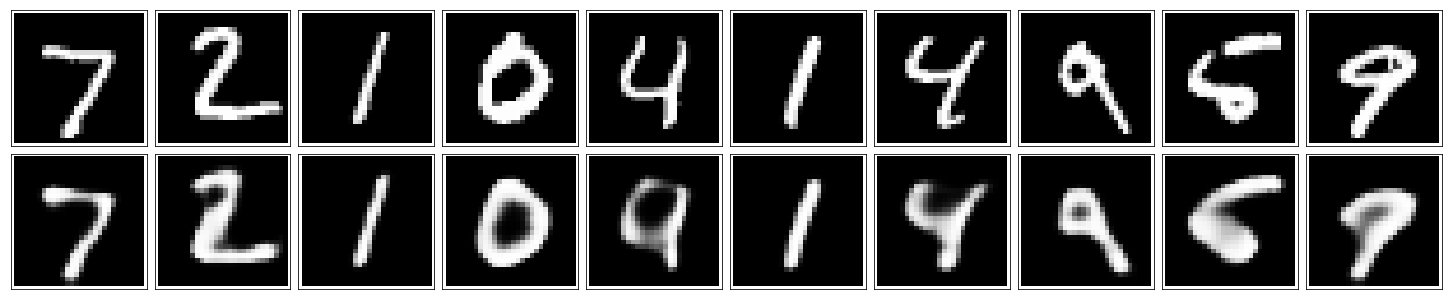

In [135]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [136]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [144]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')


def conv2d(x, W, b, strides = 1):
    x = tf.nn.conv2d(x, W, strides = [1, strides, strides, 1], padding = 'SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def conv2d_no_act(x, W, b, strides = 1):
    x = tf.nn.conv2d(x, W, strides = [1, strides, strides, 1], padding = 'SAME')
    x = tf.nn.bias_add(x, b)
    return x

def maxpool(x, k = 2):
    return tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1],
                         padding = 'SAME')
    

weights = {
    'wc1' : tf.Variable(tf.truncated_normal([3, 3, 1, 32], stddev = 0.1)),
    'wc2' : tf.Variable(tf.truncated_normal([3, 3, 32, 32], stddev = 0.1)),
    'wc3' : tf.Variable(tf.truncated_normal([3, 3, 32, 16], stddev = 0.1)),
    'wc4' : tf.Variable(tf.truncated_normal([3, 3, 16, 16], stddev = 0.1)),
    'wc5' : tf.Variable(tf.truncated_normal([3, 3, 16, 32], stddev = 0.1)),
    'wc6' : tf.Variable(tf.truncated_normal([3, 3, 32, 32], stddev = 0.1)),
    'wc7' : tf.Variable(tf.truncated_normal([3, 3, 32, 1], stddev = 0.1))


}

biases = {
    'bc1' : tf.Variable(tf.truncated_normal([32])),
    'bc2' : tf.Variable(tf.truncated_normal([32])),
    'bc3' : tf.Variable(tf.truncated_normal([16])),
    'bc4' : tf.Variable(tf.truncated_normal([16])),
    'bc5' : tf.Variable(tf.truncated_normal([32])),
    'bc6' : tf.Variable(tf.truncated_normal([32])),
    'bc7' : tf.Variable(tf.truncated_normal([1]))
}


### Encoder
conv1 = conv2d(inputs_, weights['wc1'], biases['bc1'])
# Now 28x28x32
maxpool1 = maxpool(conv1, k = 2)
# Now 14x14x32
conv2 = conv2d(maxpool1, weights['wc2'], biases['bc2'])
# Now 14x14x32
maxpool2 = maxpool(conv2, k = 2)
# Now 7x7x32
conv3 = conv2d(maxpool2, weights['wc3'], biases['bc3'])
# Now 7x7x16
encoded = maxpool(conv3, k = 2)
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x16
conv4 = conv2d(upsample1, weights['wc4'], biases['bc4'])
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14, 14))
# Now 14x14x16
conv5 = conv2d(upsample2, weights['wc5'], biases['bc5'])
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28, 28))
# Now 28x28x32
conv6 = conv2d(upsample3, weights['wc6'], biases['bc6'])
# Now 28x28x32

logits = conv2d_no_act(conv6, weights['wc7'], biases['bc7'])
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = targets_)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [145]:
sess = tf.Session()

In [146]:
epochs = 3
batch_size = 100
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/3... Training loss: 0.4669
Epoch: 1/3... Training loss: 0.4119
Epoch: 1/3... Training loss: 0.4012
Epoch: 1/3... Training loss: 0.4000
Epoch: 1/3... Training loss: 0.3867
Epoch: 1/3... Training loss: 0.3782
Epoch: 1/3... Training loss: 0.3756
Epoch: 1/3... Training loss: 0.3507
Epoch: 1/3... Training loss: 0.3524
Epoch: 1/3... Training loss: 0.3481
Epoch: 1/3... Training loss: 0.3400
Epoch: 1/3... Training loss: 0.3264
Epoch: 1/3... Training loss: 0.3242
Epoch: 1/3... Training loss: 0.3258
Epoch: 1/3... Training loss: 0.3105
Epoch: 1/3... Training loss: 0.3071
Epoch: 1/3... Training loss: 0.3087
Epoch: 1/3... Training loss: 0.2999
Epoch: 1/3... Training loss: 0.3036
Epoch: 1/3... Training loss: 0.2920
Epoch: 1/3... Training loss: 0.2845
Epoch: 1/3... Training loss: 0.2970
Epoch: 1/3... Training loss: 0.2869
Epoch: 1/3... Training loss: 0.2879
Epoch: 1/3... Training loss: 0.2713
Epoch: 1/3... Training loss: 0.2818
Epoch: 1/3... Training loss: 0.2749
Epoch: 1/3... Training loss:

Epoch: 1/3... Training loss: 0.1782
Epoch: 1/3... Training loss: 0.1769
Epoch: 1/3... Training loss: 0.1830
Epoch: 1/3... Training loss: 0.1786
Epoch: 1/3... Training loss: 0.1792
Epoch: 1/3... Training loss: 0.1776
Epoch: 1/3... Training loss: 0.1736
Epoch: 1/3... Training loss: 0.1795
Epoch: 1/3... Training loss: 0.1783
Epoch: 1/3... Training loss: 0.1772
Epoch: 1/3... Training loss: 0.1698
Epoch: 1/3... Training loss: 0.1823
Epoch: 1/3... Training loss: 0.1837
Epoch: 1/3... Training loss: 0.1787
Epoch: 1/3... Training loss: 0.1777
Epoch: 1/3... Training loss: 0.1630
Epoch: 1/3... Training loss: 0.1769
Epoch: 1/3... Training loss: 0.1757
Epoch: 1/3... Training loss: 0.1739
Epoch: 1/3... Training loss: 0.1736
Epoch: 1/3... Training loss: 0.1719
Epoch: 1/3... Training loss: 0.1688
Epoch: 1/3... Training loss: 0.1674
Epoch: 1/3... Training loss: 0.1814
Epoch: 1/3... Training loss: 0.1791
Epoch: 1/3... Training loss: 0.1701
Epoch: 1/3... Training loss: 0.1803
Epoch: 1/3... Training loss:

Epoch: 1/3... Training loss: 0.1573
Epoch: 1/3... Training loss: 0.1462
Epoch: 1/3... Training loss: 0.1539
Epoch: 1/3... Training loss: 0.1592
Epoch: 1/3... Training loss: 0.1564
Epoch: 1/3... Training loss: 0.1527
Epoch: 1/3... Training loss: 0.1505
Epoch: 1/3... Training loss: 0.1556
Epoch: 1/3... Training loss: 0.1504
Epoch: 1/3... Training loss: 0.1558
Epoch: 1/3... Training loss: 0.1495
Epoch: 1/3... Training loss: 0.1504
Epoch: 1/3... Training loss: 0.1515
Epoch: 1/3... Training loss: 0.1540
Epoch: 1/3... Training loss: 0.1504
Epoch: 1/3... Training loss: 0.1534
Epoch: 1/3... Training loss: 0.1581
Epoch: 1/3... Training loss: 0.1519
Epoch: 1/3... Training loss: 0.1470
Epoch: 1/3... Training loss: 0.1533
Epoch: 1/3... Training loss: 0.1557
Epoch: 1/3... Training loss: 0.1560
Epoch: 1/3... Training loss: 0.1465
Epoch: 1/3... Training loss: 0.1546
Epoch: 1/3... Training loss: 0.1536
Epoch: 1/3... Training loss: 0.1525
Epoch: 1/3... Training loss: 0.1491
Epoch: 1/3... Training loss:

Epoch: 2/3... Training loss: 0.1374
Epoch: 2/3... Training loss: 0.1453
Epoch: 2/3... Training loss: 0.1464
Epoch: 2/3... Training loss: 0.1431
Epoch: 2/3... Training loss: 0.1436
Epoch: 2/3... Training loss: 0.1487
Epoch: 2/3... Training loss: 0.1429
Epoch: 2/3... Training loss: 0.1524
Epoch: 2/3... Training loss: 0.1474
Epoch: 2/3... Training loss: 0.1411
Epoch: 2/3... Training loss: 0.1408
Epoch: 2/3... Training loss: 0.1384
Epoch: 2/3... Training loss: 0.1431
Epoch: 2/3... Training loss: 0.1381
Epoch: 2/3... Training loss: 0.1488
Epoch: 2/3... Training loss: 0.1495
Epoch: 2/3... Training loss: 0.1453
Epoch: 2/3... Training loss: 0.1408
Epoch: 2/3... Training loss: 0.1409
Epoch: 2/3... Training loss: 0.1445
Epoch: 2/3... Training loss: 0.1413
Epoch: 2/3... Training loss: 0.1432
Epoch: 2/3... Training loss: 0.1488
Epoch: 2/3... Training loss: 0.1466
Epoch: 2/3... Training loss: 0.1417
Epoch: 2/3... Training loss: 0.1471
Epoch: 2/3... Training loss: 0.1491
Epoch: 2/3... Training loss:

Epoch: 2/3... Training loss: 0.1282
Epoch: 2/3... Training loss: 0.1365
Epoch: 2/3... Training loss: 0.1311
Epoch: 2/3... Training loss: 0.1431
Epoch: 2/3... Training loss: 0.1385
Epoch: 2/3... Training loss: 0.1350
Epoch: 2/3... Training loss: 0.1421
Epoch: 2/3... Training loss: 0.1358
Epoch: 2/3... Training loss: 0.1335
Epoch: 2/3... Training loss: 0.1460
Epoch: 2/3... Training loss: 0.1369
Epoch: 2/3... Training loss: 0.1379
Epoch: 2/3... Training loss: 0.1342
Epoch: 2/3... Training loss: 0.1384
Epoch: 2/3... Training loss: 0.1422
Epoch: 2/3... Training loss: 0.1403
Epoch: 2/3... Training loss: 0.1318
Epoch: 2/3... Training loss: 0.1429
Epoch: 2/3... Training loss: 0.1383
Epoch: 2/3... Training loss: 0.1345
Epoch: 2/3... Training loss: 0.1388
Epoch: 2/3... Training loss: 0.1314
Epoch: 2/3... Training loss: 0.1334
Epoch: 2/3... Training loss: 0.1415
Epoch: 2/3... Training loss: 0.1350
Epoch: 2/3... Training loss: 0.1402
Epoch: 2/3... Training loss: 0.1374
Epoch: 2/3... Training loss:

Epoch: 2/3... Training loss: 0.1369
Epoch: 2/3... Training loss: 0.1223
Epoch: 2/3... Training loss: 0.1314
Epoch: 2/3... Training loss: 0.1398
Epoch: 2/3... Training loss: 0.1310
Epoch: 2/3... Training loss: 0.1370
Epoch: 2/3... Training loss: 0.1309
Epoch: 2/3... Training loss: 0.1272
Epoch: 2/3... Training loss: 0.1319
Epoch: 2/3... Training loss: 0.1342
Epoch: 2/3... Training loss: 0.1378
Epoch: 2/3... Training loss: 0.1264
Epoch: 2/3... Training loss: 0.1329
Epoch: 2/3... Training loss: 0.1299
Epoch: 2/3... Training loss: 0.1301
Epoch: 2/3... Training loss: 0.1338
Epoch: 2/3... Training loss: 0.1338
Epoch: 2/3... Training loss: 0.1341
Epoch: 2/3... Training loss: 0.1294
Epoch: 2/3... Training loss: 0.1349
Epoch: 2/3... Training loss: 0.1295
Epoch: 2/3... Training loss: 0.1408
Epoch: 2/3... Training loss: 0.1308
Epoch: 2/3... Training loss: 0.1310
Epoch: 2/3... Training loss: 0.1346
Epoch: 2/3... Training loss: 0.1371
Epoch: 2/3... Training loss: 0.1287
Epoch: 2/3... Training loss:

Epoch: 3/3... Training loss: 0.1297
Epoch: 3/3... Training loss: 0.1287
Epoch: 3/3... Training loss: 0.1308
Epoch: 3/3... Training loss: 0.1293
Epoch: 3/3... Training loss: 0.1215
Epoch: 3/3... Training loss: 0.1316
Epoch: 3/3... Training loss: 0.1316
Epoch: 3/3... Training loss: 0.1302
Epoch: 3/3... Training loss: 0.1255
Epoch: 3/3... Training loss: 0.1273
Epoch: 3/3... Training loss: 0.1265
Epoch: 3/3... Training loss: 0.1197
Epoch: 3/3... Training loss: 0.1302
Epoch: 3/3... Training loss: 0.1295
Epoch: 3/3... Training loss: 0.1265
Epoch: 3/3... Training loss: 0.1304
Epoch: 3/3... Training loss: 0.1266
Epoch: 3/3... Training loss: 0.1309
Epoch: 3/3... Training loss: 0.1285
Epoch: 3/3... Training loss: 0.1295
Epoch: 3/3... Training loss: 0.1317
Epoch: 3/3... Training loss: 0.1308
Epoch: 3/3... Training loss: 0.1328
Epoch: 3/3... Training loss: 0.1296
Epoch: 3/3... Training loss: 0.1256
Epoch: 3/3... Training loss: 0.1299
Epoch: 3/3... Training loss: 0.1309
Epoch: 3/3... Training loss:

Epoch: 3/3... Training loss: 0.1291
Epoch: 3/3... Training loss: 0.1329
Epoch: 3/3... Training loss: 0.1250
Epoch: 3/3... Training loss: 0.1299
Epoch: 3/3... Training loss: 0.1281
Epoch: 3/3... Training loss: 0.1261
Epoch: 3/3... Training loss: 0.1324
Epoch: 3/3... Training loss: 0.1282
Epoch: 3/3... Training loss: 0.1243
Epoch: 3/3... Training loss: 0.1301
Epoch: 3/3... Training loss: 0.1240
Epoch: 3/3... Training loss: 0.1258
Epoch: 3/3... Training loss: 0.1322
Epoch: 3/3... Training loss: 0.1307
Epoch: 3/3... Training loss: 0.1236
Epoch: 3/3... Training loss: 0.1258
Epoch: 3/3... Training loss: 0.1229
Epoch: 3/3... Training loss: 0.1348
Epoch: 3/3... Training loss: 0.1311
Epoch: 3/3... Training loss: 0.1291
Epoch: 3/3... Training loss: 0.1318
Epoch: 3/3... Training loss: 0.1284
Epoch: 3/3... Training loss: 0.1219
Epoch: 3/3... Training loss: 0.1270
Epoch: 3/3... Training loss: 0.1212
Epoch: 3/3... Training loss: 0.1294
Epoch: 3/3... Training loss: 0.1216
Epoch: 3/3... Training loss:

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

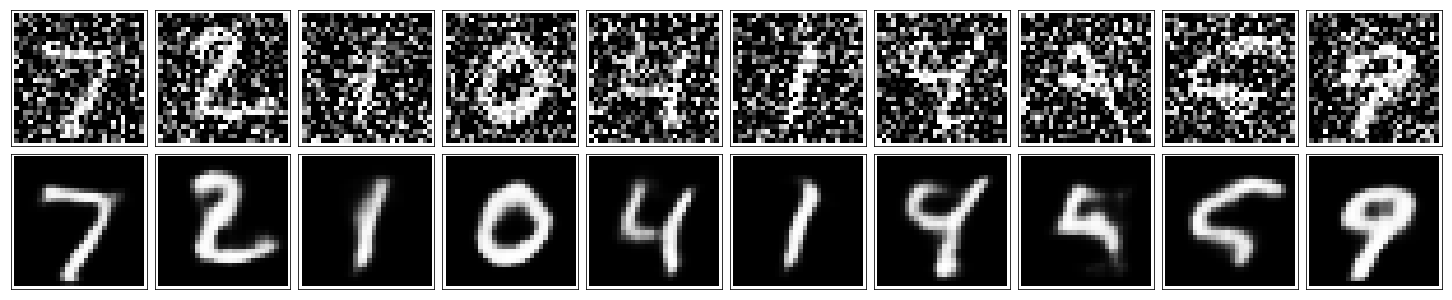

In [147]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)